# Generative Adversarial Network

In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from util import suppress_tf_warning,get_vars,gpu_sess
suppress_tf_warning()
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
print ("TF version: %s"%(tf.__version__))

TF version: 1.15.0


### Define GAN

In [2]:
class GenerativeAdversarialNetworkClass(object):
    """
    Generative Adversarial Network
    """
    def __init__(self,name='gan',x_dim=784,img_dim=[28,28,1],z_dim=16,
                 gf_dim=64,df_dim=64):
        """
        Initialize
        """
        self.name = name
        self.x_dim = x_dim
        self.img_dim = img_dim
        self.z_dim = z_dim
        
        self.gf_dim = gf_dim # G final conv feature dim
        self.df_dim = df_dim # D final conv feature dim
        
        self.build_model()
        self.build_graph()
        
    def build_model(self):
        """
        Build model
        """
        
        ki = tf.random_normal_initializer(mean=0.0,stddev=0.1)
        bi = tf.constant_initializer(value=0.0)
        
        self.ph_x_real = tf.placeholder(dtype=tf.float32,shape=[None,self.x_dim],name='x_real')
        self.ph_z = tf.placeholder(dtype=tf.float32,shape=[None,self.z_dim],name='z')
        self.ph_is_train = tf.placeholder(dtype=tf.bool,name='is_train')
        
        # Generator (ph_z -> g)
        self.model = {}
        s,s4,s8 = self.img_dim[0],self.img_dim[0]//4,self.img_dim[0]//8
        with tf.variable_scope('G',reuse=False):
            net = self.ph_z # [N x z_dim]
            # Linear
            net = tf.layers.dense(net,self.gf_dim*s8*s8,activation=None,
                                  kernel_initializer=ki,bias_initializer=bi,
                                  name='lin0')
            self.model['G/dense'] = net
            # Reshape
            net = tf.reshape(net,[-1,s8,s8,self.gf_dim//1]) # [N x 3 x 3 x gf_dim]
            net = tf.layers.batch_normalization(net,training=self.ph_is_train) 
            self.model['G/lin_reshape'] = net # [N x 3 x 3 x gf_dim]
            # Deconv 1
            # - output = input * stride + filter - stride  # VALID
            # - output = input * stride - stride + 1  # SAME 
            net = tf.layers.conv2d_transpose(
                net,filters=self.gf_dim//2,kernel_size=[5,5],strides=1,activation=tf.nn.relu,
                kernel_initializer=ki,bias_initializer=bi,padding='valid',
                name='deconv1')
            net = tf.layers.batch_normalization(net,training=self.ph_is_train)
            self.model['G/deconv1'] = net # [N x 7 x 7 x gf_dim//2]
            # Deconv 2
            net = tf.layers.conv2d_transpose(
                net,filters=self.gf_dim//4,kernel_size=[5,5],strides=2,activation=tf.nn.relu,
                kernel_initializer=ki,bias_initializer=bi,padding='same',
                name='deconv2')
            self.model['G/deconv2'] = net # [N x 14 x 14 x gf_dim//4]
            # Deconv 3
            net = tf.layers.conv2d_transpose(
                net,filters=1,kernel_size=[5,5],strides=2,activation=None,
                kernel_initializer=ki,bias_initializer=bi,padding='same',
                name='deconv3')
            self.model['G/deconv3'] = net # [N x 28 x 28 x 1]
            self.g = tf.nn.sigmoid(net) # [N x 28 x 28 x 1]
        
        # Discriminator (ph_x_real -> d_real,d_real_logit) 
        with tf.variable_scope('D',reuse=False):
            net = self.ph_x_real # [N x x_dim]
            net = tf.reshape(net,shape=[-1]+self.img_dim)
            # Conv 1
            net = tf.layers.conv2d(
                net,filters=self.df_dim//4,kernel_size=[5,5],strides=2,activation=tf.nn.leaky_relu,
                kernel_initializer=ki,bias_initializer=bi,padding='same',
                name='conv1')
            self.model['D/conv1'] = net
            # Conv 2
            net = tf.layers.conv2d(
                net,filters=self.df_dim//2,kernel_size=[5,5],strides=2,activation=tf.nn.leaky_relu,
                kernel_initializer=ki,bias_initializer=bi,padding='same',
                name='conv2')
            self.model['D/conv2'] = net
            # Conv 3
            net = tf.layers.conv2d(
                net,filters=self.df_dim//1,kernel_size=[5,5],strides=2,activation=tf.nn.leaky_relu,
                kernel_initializer=ki,bias_initializer=bi,padding='same',
                name='conv3')
            self.model['D/conv3'] = net
            # Densse
            net = tf.layers.flatten(net,name='flatten')
            net = tf.layers.dense(net,1,activation=None,
                                  kernel_initializer=ki,bias_initializer=bi,
                                  name='D/dense')
            self.model['D/logit'] = net
            self.d_real,self.d_real_logit = net,tf.nn.sigmoid(net,name='D/sigmoid')
            
        # Discriminator (g -> d_fake,d_fake_logit)
        with tf.variable_scope('D',reuse=True):
            net = self.g 
            net = tf.reshape(net,shape=[-1]+self.img_dim)
            net = tf.layers.conv2d(
                net,filters=self.df_dim//4,kernel_size=[5,5],strides=2,activation=tf.nn.leaky_relu,
                kernel_initializer=ki,bias_initializer=bi,padding='same',
                name='conv1')
            net = tf.layers.conv2d(
                net,filters=self.df_dim//2,kernel_size=[5,5],strides=2,activation=tf.nn.leaky_relu,
                kernel_initializer=ki,bias_initializer=bi,padding='same',
                name='conv2')
            net = tf.layers.conv2d(
                net,filters=self.df_dim//1,kernel_size=[5,5],strides=2,activation=tf.nn.leaky_relu,
                kernel_initializer=ki,bias_initializer=bi,padding='same',
                name='conv3')
            net = tf.layers.flatten(net,name='flatten')
            net = tf.layers.dense(net,1,activation=None,
                                  kernel_initializer=ki,bias_initializer=bi,
                                  name='D/dense')
            self.d_fake,self.d_fake_logit = net,tf.nn.sigmoid(net,name='D/sigmoid')
            
        # Get variables
        self.g_vars = get_vars('G')
        self.d_vars = get_vars('D')
            
    def build_graph(self):
        """
        Build graph
        """
        tf_sigce = tf.nn.sigmoid_cross_entropy_with_logits
        self.d_losses = 0.5*tf_sigce(logits=self.d_real_logit,labels=tf.ones_like(self.d_real)) + \
            0.5*tf_sigce(logits=self.d_fake_logit,labels=tf.zeros_like(self.d_fake)) # [N]
        self.d_loss = tf.reduce_mean(self.d_losses) # [1]
        
        self.g_losses = tf_sigce(logits=self.d_fake_logit,labels=tf.ones_like(self.d_fake)) # [N]
        self.g_loss = tf.reduce_mean(self.g_losses) # [1]
        
        # Optimizer
        adam = tf.train.AdamOptimizer(learning_rate=1e-4,beta1=0.5)        
        self.update_ops = tf.compat.v1.get_collection(tf.GraphKeys.UPDATE_OPS) # BN
        self.g_optm = adam.minimize(self.g_loss, var_list=self.g_vars)
        self.g_optm = tf.group([self.g_optm,self.update_ops])
        self.d_optm = adam.minimize(self.d_loss, var_list=self.d_vars)
        
    def update(self,sess,x_batch,z_batch):
        """
        Update
        """
        feeds = {self.ph_x_real:x_batch,self.ph_z:z_batch,self.ph_is_train:True}
        g_loss_val,d_loss_val,_,_ = sess.run(
            [self.g_loss,self.d_loss,self.d_optm,self.g_optm],feed_dict=feeds)
        return g_loss_val,d_loss_val
        
print ("Ready.")

Ready.


### Training data

In [3]:
(x_train,y_train), (x_test,y_test) = mnist.load_data() 
x,y = x_train.reshape(60000,784)/255.0,y_train
n,x_dim = x.shape[0],x.shape[1]
print ("n:[%d] x_dim:[%d]."%(n,x_dim))

11493376/11490434 [==============================] - 1s 0us/step
n:[60000] x_dim:[784].


### Instantiate GAN

In [4]:
tf.reset_default_graph()
sess = gpu_sess()
G = GenerativeAdversarialNetworkClass(
    name='gan',x_dim=784,img_dim=[28, 28, 1],z_dim=16,gf_dim=64,df_dim=64)
print ("[%s] instantiated."%(G.name))

[gan] instantiated.


### GAN layers

#### Generator network

In [5]:
G.model['G/dense']

<tf.Tensor 'G/lin0/BiasAdd:0' shape=(?, 576) dtype=float32>

In [6]:
G.model['G/lin_reshape']

<tf.Tensor 'G/batch_normalization/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>

In [7]:
G.model['G/deconv1']

<tf.Tensor 'G/batch_normalization_1/cond/Merge:0' shape=(?, 7, 7, 32) dtype=float32>

In [8]:
G.model['G/deconv2']

<tf.Tensor 'G/deconv2/Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [9]:
G.model['G/deconv3']

<tf.Tensor 'G/deconv3/BiasAdd:0' shape=(?, 28, 28, 1) dtype=float32>

In [10]:
G.g

<tf.Tensor 'G/Sigmoid:0' shape=(?, 28, 28, 1) dtype=float32>

#### Discriminator network

In [11]:
G.model['D/conv1']

<tf.Tensor 'D/conv1/LeakyRelu:0' shape=(?, 14, 14, 16) dtype=float32>

In [12]:
G.model['D/conv2']

<tf.Tensor 'D/conv2/LeakyRelu:0' shape=(?, 7, 7, 32) dtype=float32>

In [13]:
G.model['D/conv3']

<tf.Tensor 'D/conv3/LeakyRelu:0' shape=(?, 4, 4, 64) dtype=float32>

In [14]:
G.model['D/logit']

<tf.Tensor 'D/D/dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [15]:
G.g_vars

[<tf.Variable 'G/lin0/kernel:0' shape=(16, 576) dtype=float32_ref>,
 <tf.Variable 'G/lin0/bias:0' shape=(576,) dtype=float32_ref>,
 <tf.Variable 'G/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'G/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'G/batch_normalization/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'G/batch_normalization/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'G/deconv1/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'G/deconv1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'G/batch_normalization_1/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'G/batch_normalization_1/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'G/batch_normalization_1/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'G/batch_normalization_1/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'G/deconv2/kernel:0' shape=(5, 5, 16, 32) dtype=floa

In [16]:
G.d_vars

[<tf.Variable 'D/conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>,
 <tf.Variable 'D/conv1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'D/conv2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'D/conv2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'D/conv3/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'D/conv3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'D/D/dense/kernel:0' shape=(1024, 1) dtype=float32_ref>,
 <tf.Variable 'D/D/dense/bias:0' shape=(1,) dtype=float32_ref>]

### Merge images into an image

In [17]:
def merge_imgs(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 1))
    for idx, image in enumerate(images):
        image = image.reshape(28, 28)
        i = idx % size[1]
        j = idx // size[1]        
        img[j*h:j*h+h, i*w:i*w+w, 0] = image
    return img

### Loop

[0/30] g_loss:[0.677] d_loss:[0.525].


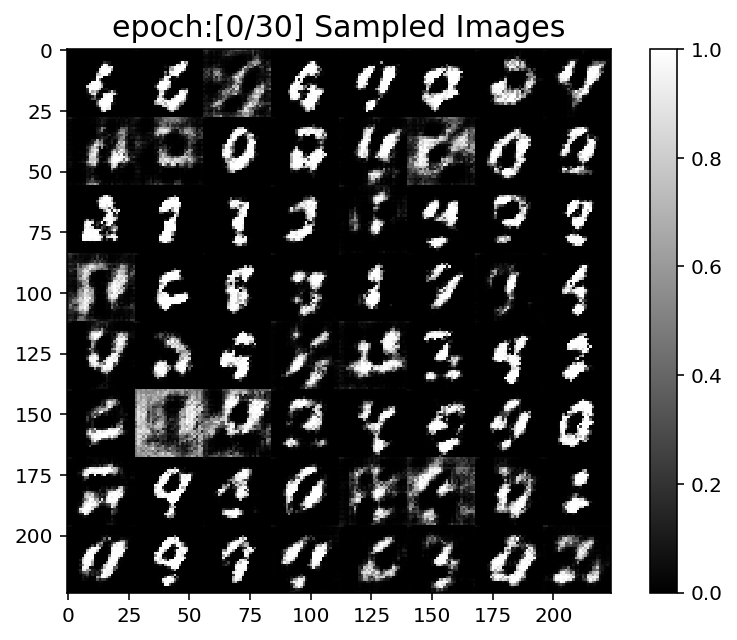

[1/30] g_loss:[0.615] d_loss:[0.647].
[2/30] g_loss:[0.615] d_loss:[0.654].
[3/30] g_loss:[0.618] d_loss:[0.668].
[4/30] g_loss:[0.625] d_loss:[0.675].
[5/30] g_loss:[0.628] d_loss:[0.679].


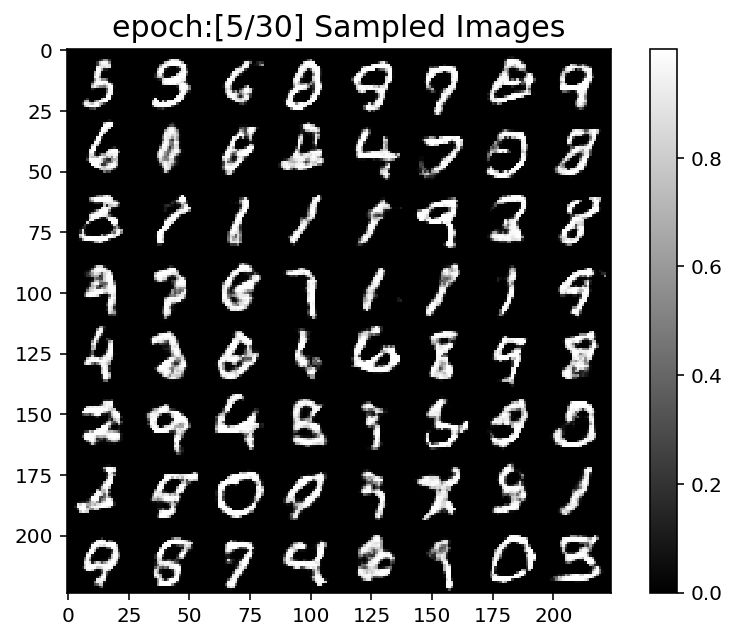

[6/30] g_loss:[0.631] d_loss:[0.680].
[7/30] g_loss:[0.630] d_loss:[0.681].
[8/30] g_loss:[0.634] d_loss:[0.682].
[9/30] g_loss:[0.636] d_loss:[0.683].
[10/30] g_loss:[0.636] d_loss:[0.683].


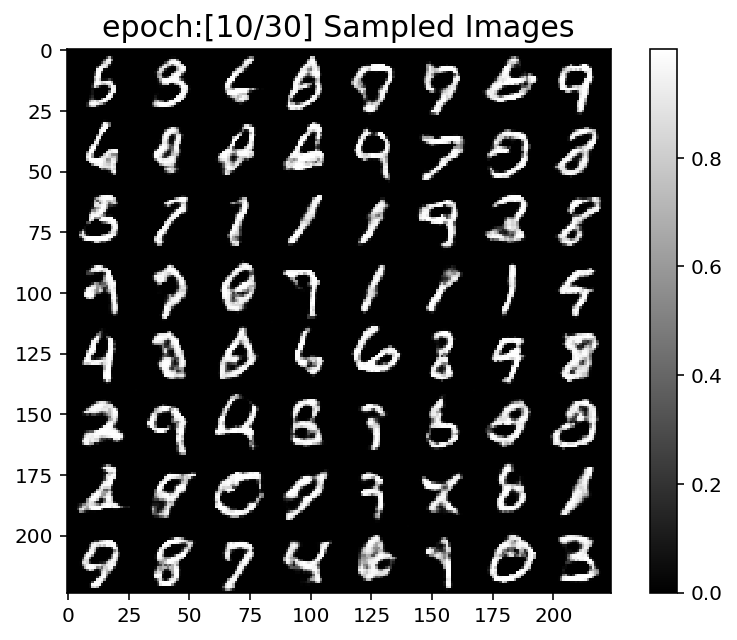

[11/30] g_loss:[0.632] d_loss:[0.682].
[12/30] g_loss:[0.631] d_loss:[0.682].
[13/30] g_loss:[0.631] d_loss:[0.682].
[14/30] g_loss:[0.631] d_loss:[0.681].
[15/30] g_loss:[0.631] d_loss:[0.681].


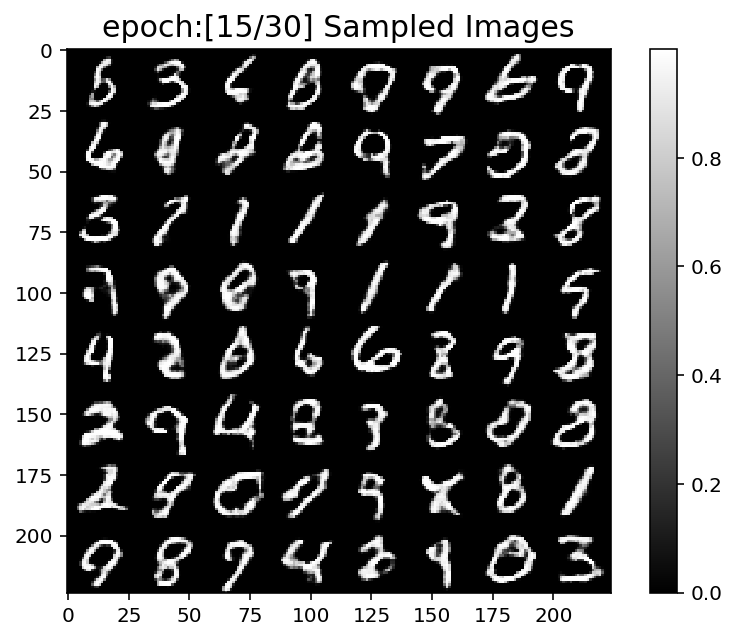

[16/30] g_loss:[0.629] d_loss:[0.681].
[17/30] g_loss:[0.627] d_loss:[0.680].
[18/30] g_loss:[0.629] d_loss:[0.680].
[19/30] g_loss:[0.627] d_loss:[0.680].
[20/30] g_loss:[0.627] d_loss:[0.679].


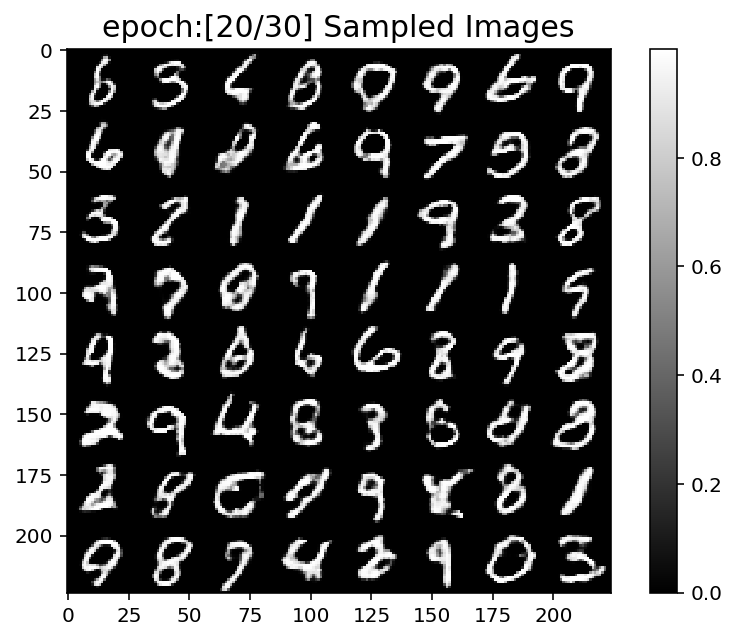

[21/30] g_loss:[0.626] d_loss:[0.679].
[22/30] g_loss:[0.626] d_loss:[0.679].
[23/30] g_loss:[0.626] d_loss:[0.678].
[24/30] g_loss:[0.625] d_loss:[0.678].
[25/30] g_loss:[0.631] d_loss:[0.679].


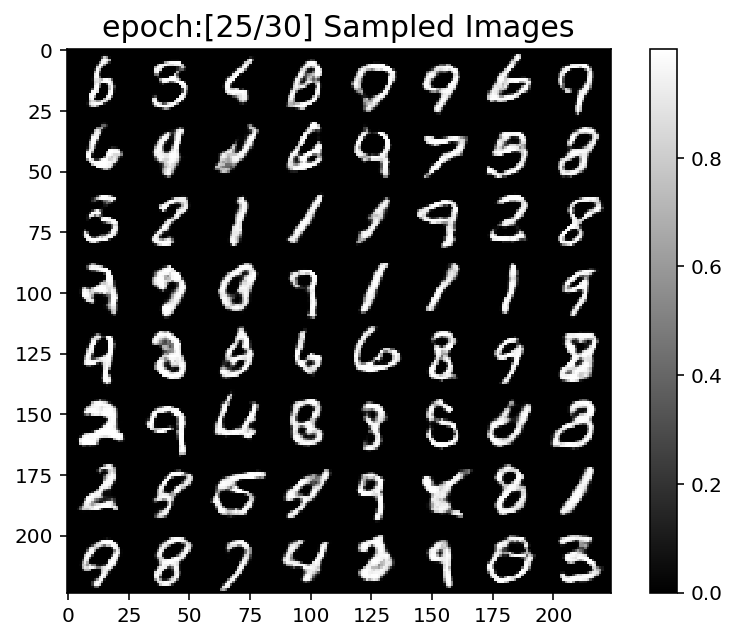

[26/30] g_loss:[0.626] d_loss:[0.678].
[27/30] g_loss:[0.625] d_loss:[0.677].
[28/30] g_loss:[0.624] d_loss:[0.676].
[29/30] g_loss:[0.623] d_loss:[0.676].


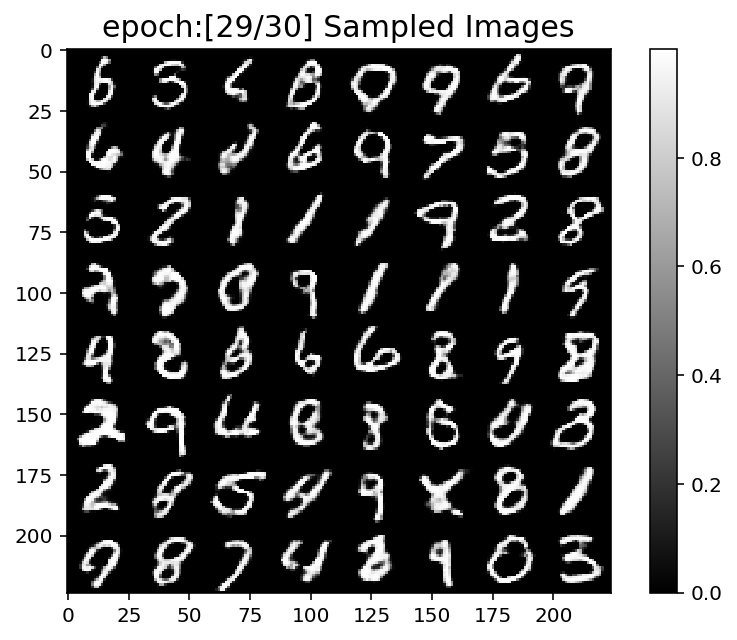

Done.


In [18]:
sess.run(tf.global_variables_initializer())
sample_size,sample_grid = 64,[8,8]
z_sample = np.random.uniform(-1, 1, size=(sample_size, G.z_dim))

start_time = time.time() 
max_epoch,batch_size,print_every,plot_every = 30,33,1,5
for epoch in range(int(max_epoch)):
    
    r_idx = np.random.permutation(n)
    max_iter = np.ceil(n/batch_size).astype(np.int) # number of iterations
    g_loss_val_sum,d_loss_val_sum = 0,0
    for it in range(max_iter):
        b_idx = r_idx[batch_size*(it):batch_size*(it+1)]
        x_batch = x[b_idx,:]
        z_batch = np.random.uniform(-1,1,[len(b_idx),G.z_dim]).astype(np.float32)
        # Update
        g_loss_val,d_loss_val = G.update(sess,x_batch,z_batch)
        g_loss_val_sum += g_loss_val
        d_loss_val_sum += d_loss_val
    g_loss_val_avg,d_loss_val_avg = g_loss_val_sum/max_iter,d_loss_val_sum/max_iter
    
    # Print
    if ((epoch%print_every)==0) or (epoch==(max_epoch-1)):
        print ("[%d/%d] g_loss:[%.3f] d_loss:[%.3f]."%
               (epoch,max_epoch,g_loss_val_avg,d_loss_val_avg))
        
    # Plot 
    if ((epoch%plot_every)==0) or (epoch==(max_epoch-1)):
        feeds = {G.ph_z:z_sample,G.ph_is_train:False}
        generated_imgs = sess.run([G.g],feed_dict=feeds)
        concat_imgs = np.concatenate(generated_imgs)
        img_merged = merge_imgs(concat_imgs,sample_grid)
        plt.figure(figsize=(7,5))
        plt.imshow(img_merged[:,:,0],cmap='gray',interpolation='nearest',aspect='equal')
        plt.title('epoch:[%d/%d] Sampled Images'%(epoch,max_epoch),fontsize=15)
        plt.colorbar(); plt.show()
    
print ("Done.")